## Réseau maxout convolutionnel, avec données prétraitées de CIFAR-10  

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Loss: 1.3072098979864584
Epoch [2/20], Loss: 0.919343237681767
Epoch [3/20], Loss: 0.7395930094715885
Epoch [4/20], Loss: 0.5863934169949778
Epoch [5/20], Loss: 0.4380758153965406
Epoch [6/20], Loss: 0.2988623769291679
Epoch [7/20], Loss: 0.19283201343968243
Epoch [8/20], Loss: 0.11964199986175426
Epoch [9/20], Loss: 0.09110588090889671
Epoch [10/20], Loss: 0.07344055065022939
Epoch [11/20], Loss: 0.06869399098648458
Epoch [12/20], Loss: 0.06091997875650997
Epoch [13/20], Loss: 0.05930643651457003
Epoch [14/20], Loss: 0.047130638547866935
Epoch [15/20], Loss: 0.045364486673773005
Epoch [16/20], Loss: 0.048624209831724816
Epoch [17/20], Loss: 0.03649795975196985
Epoch [18/20], Loss: 0.04378654325836162
Epoch [19/20], Loss: 0.04603128343292981
Epoch [20/20], Loss: 0.04292276745026126
Accuracy on adversarial examples: 9.97%
Average probability assigned to incorrect predictions: 90.25%


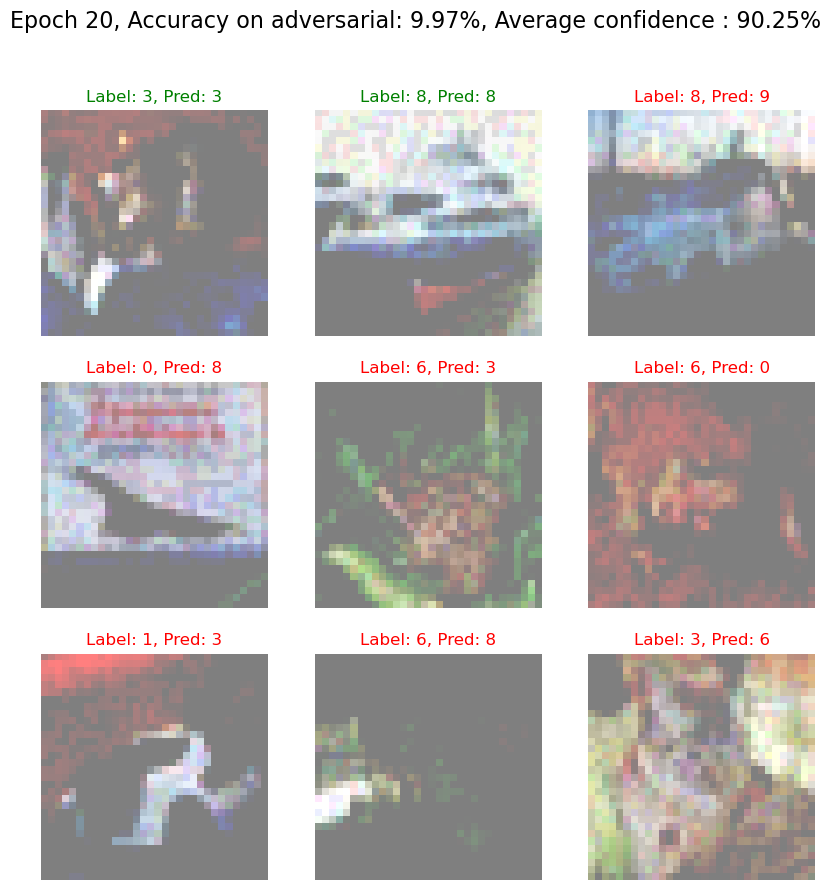

In [34]:
# @title Bonne Version, rnn convolutionnel maxout et données prétraitées de CIFAR-10 avec epsilon = 0.1, et optimisateur : Adam
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1) 

    return adversarial_images

# Modèle CNN avec Maxout (modification du modèle pour utiliser Maxout)
class ConvMaxoutNet(nn.Module):
    def __init__(self):
        super(ConvMaxoutNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*8*8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.maxout = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.maxout(x)
        x = torch.relu(self.conv2(x))
        x = self.maxout(x)
        x = x.view(-1, 64*8*8)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Charger les données CIFAR-10
def load_data():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, test_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, test_loader, epsilon):
    model.eval()

    correct = 0
    total = 0
    incorrect_probs = []  

    for images, labels in test_loader:
        adversarial_images = FGSM(model, images, labels, epsilon)

        outputs = model(adversarial_images)
        probs = nn.Softmax(dim=1)(outputs)  
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:  
                incorrect_probs.append(probs[i, predicted[i]].item())

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')

    if incorrect_probs:
        avg_incorrect_prob = np.mean(incorrect_probs)*100
        print(f'Average probability assigned to incorrect predictions: {avg_incorrect_prob:.2f}%')
    else:
        avg_incorrect_prob = 0
        print('No incorrect predictions to calculate average probability.')

    return accuracy, avg_incorrect_prob

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)  
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%, Average confidence : {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.1  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    train_loader, test_loader = load_data()

    model = ConvMaxoutNet()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_on_normal_data(model, train_loader, optimizer, epochs)

    accuracy, avg_incorrect_prob = test_on_adversarial_data(model, test_loader, epsilon)

    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Loss: 1.523592886717423
Epoch [2/20], Loss: 1.0606354821063673
Epoch [3/20], Loss: 0.8563758623417076
Epoch [4/20], Loss: 0.6997542423970254
Epoch [5/20], Loss: 0.5520726561431994
Epoch [6/20], Loss: 0.41100072712087266
Epoch [7/20], Loss: 0.2781102589576903
Epoch [8/20], Loss: 0.17691840851188773
Epoch [9/20], Loss: 0.10737294884746337
Epoch [10/20], Loss: 0.07074546213309421
Epoch [11/20], Loss: 0.0445873719643649
Epoch [12/20], Loss: 0.04505436863277412
Epoch [13/20], Loss: 0.028179238198885976
Epoch [14/20], Loss: 0.03492497014382895
Epoch [15/20], Loss: 0.02110793624419238
Epoch [16/20], Loss: 0.013001054182530754
Epoch [17/20], Loss: 0.013954334972163394
Epoch [18/20], Loss: 0.004825267750300768
Epoch [19/20], Loss: 0.001099614760303787
Epoch [20/20], Loss: 0.000491313318314757
Accuracy on adversarial examples: 12.06%
Average probability assigned to incorrect predictions: 89.30


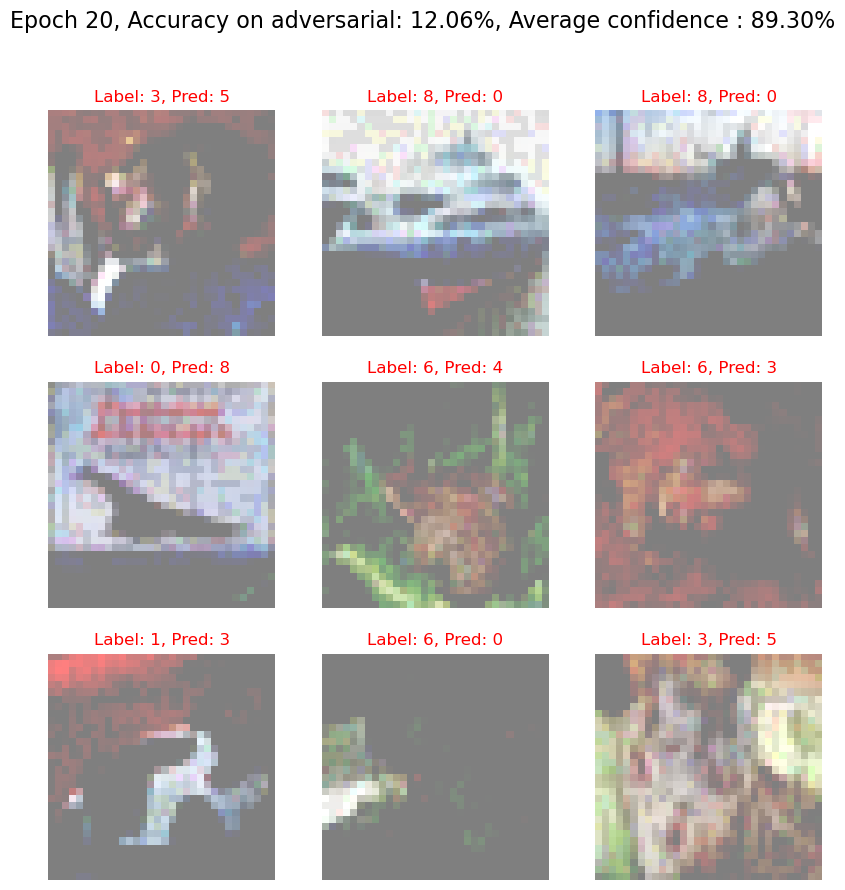

In [40]:
# @title Bonne Version, rnn convolutionnel maxout et données prétraitées de CIFAR-10 avec epsilon = 0.1, et optimisateur : SGD avec momentum (=0.9)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    return adversarial_images

# Modèle CNN avec Maxout (modification du modèle pour utiliser Maxout)
class ConvMaxoutNet(nn.Module):
    def __init__(self):
        super(ConvMaxoutNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*8*8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.maxout = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.maxout(x)
        x = torch.relu(self.conv2(x))
        x = self.maxout(x)
        x = x.view(-1, 64*8*8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Charger les données CIFAR-10
def load_data():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, test_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, test_loader, epsilon):
    model.eval()

    correct = 0
    total = 0
    incorrect_probs = [] 

    for images, labels in test_loader:
        adversarial_images = FGSM(model, images, labels, epsilon)

        outputs = model(adversarial_images)
        probs = nn.Softmax(dim=1)(outputs)  
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:
                incorrect_probs.append(probs[i, predicted[i]].item())

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')

    if incorrect_probs:
        avg_incorrect_prob = np.mean(incorrect_probs) * 100
        print(f'Average probability assigned to incorrect predictions: {avg_incorrect_prob:.2f}')
    else:
        avg_incorrect_prob = 0
        print('No incorrect predictions to calculate average probability.')

    return accuracy, avg_incorrect_prob

# Fonction pour afficher les images avec les prédictions
def plot_images(images, labels, predictions, accuracy, epoch, avg_incorrect_prob):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5)  
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%, Average confidence : {avg_incorrect_prob:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.1  # Magnitude des perturbations adversariales
    epochs = 20  # Nombre d'époques d'entraînement

    train_loader, test_loader = load_data()

    model = ConvMaxoutNet()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_on_normal_data(model, train_loader, optimizer, epochs)

    accuracy, avg_incorrect_prob = test_on_adversarial_data(model, test_loader, epsilon)

    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs, avg_incorrect_prob)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()
